In [1]:
!pip install astro-datasets numpy matplotlib albumentations

     |████████████████████████████████| 9.4 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 47.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 32.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 52.5 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 86.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 46.9 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 51.9 MB/s eta 0:00:01
     |████████████████████████████████| 33.8 MB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 28.7 MB/s eta 0:00:01
     |████████████████████████████████| 48.3 MB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 17.2 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 46.0 MB/s eta 0:00:01
     |██████████████████████████

In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-11-20 17:01:26.687365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_IllustrisTNG', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

2022-11-20 17:01:29.092396: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/Nbody_IllustrisTNG_Mtot_omegam/cmd/1.0.4.incompleteI9UXPP/cmd-train.tfreco…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/Nbody_IllustrisTNG_Mtot_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


2022-11-20 17:05:37.726619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 17:05:38.232601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_SIMBA', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/Nbody_SIMBA_Mtot_omegam/cmd/1.0.4.incompleteQ4MNOZ/cmd-train.tfrecord*...:…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/Nbody_SIMBA_Mtot_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

model.fit(cmd_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=cmd_val)

Epoch 1/50


2022-11-20 17:09:52.490611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-20 17:09:54.529491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-20 17:09:54.770427: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5fa4293ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-20 17:09:54.770460: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-11-20 17:09:54.776535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-20 17:09:54.920973: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

317/317 [==============================] - ETA: 0s - loss: 0.2648 - mse: 0.3043
Epoch 1: val_loss improved from inf to 0.08537, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 112s 309ms/step - loss: 0.2648 - mse: 0.3043 - val_loss: 0.0854 - val_mse: 0.0101 - lr: 0.0010
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.0777 - mse: 0.0373
Epoch 2: val_loss did not improve from 0.08537
317/317 [==============================] - 99s 312ms/step - loss: 0.0777 - mse: 0.0373 - val_loss: 0.0859 - val_mse: 0.0231 - lr: 0.0010
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.0525 - mse: 0.0184
Epoch 3: val_loss did not improve from 0.08537
317/317 [==============================] - 94s 297ms/step - loss: 0.0525 - mse: 0.0184 - val_loss: 0.5158 - val_mse: 0.8805 - lr: 0.0010
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.0370 - mse: 0.0059
Epoch 4: val_loss did not improve from 0.08537
317/317 [==============================] - 92s 291ms/step - loss: 0.0370 - mse: 0.0059 - val_loss: 0.1278 - val_mse: 0.0202 - lr: 0.0010
Epoch 5/50
317/317 [=================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 96s 303ms/step - loss: 0.0318 - mse: 0.0035 - val_loss: 0.0268 - val_mse: 0.0012 - lr: 0.0010
Epoch 6/50
317/317 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0022
Epoch 6: val_loss improved from 0.02681 to 0.01956, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 98s 309ms/step - loss: 0.0270 - mse: 0.0022 - val_loss: 0.0196 - val_mse: 0.0011 - lr: 0.0010
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0019
Epoch 7: val_loss did not improve from 0.01956
317/317 [==============================] - 87s 275ms/step - loss: 0.0258 - mse: 0.0019 - val_loss: 0.0603 - val_mse: 0.0050 - lr: 0.0010
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0017
Epoch 8: val_loss did not improve from 0.01956
317/317 [==============================] - 91s 288ms/step - loss: 0.0243 - mse: 0.0017 - val_loss: 0.0563 - val_mse: 0.0061 - lr: 0.0010
Epoch 9/50
317/317 [==============================] - ETA: 0s - loss: 0.0264 - mse: 0.0018
Epoch 9: val_loss did not improve from 0.01956
317/317 [==============================] - 93s 292ms/step - loss: 0.0264 - mse: 0.0018 - val_loss: 0.0319 - val_mse: 0.0015 - lr: 0.0010
Epoch 10/50
317/317 [=================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 95s 299ms/step - loss: 0.0135 - mse: 3.3699e-04 - val_loss: 0.0123 - val_mse: 3.4226e-04 - lr: 9.0000e-05
Epoch 30/50
317/317 [==============================] - ETA: 0s - loss: 0.0134 - mse: 3.2821e-04
Epoch 30: val_loss did not improve from 0.01230
317/317 [==============================] - 90s 284ms/step - loss: 0.0134 - mse: 3.2821e-04 - val_loss: 0.0138 - val_mse: 4.0660e-04 - lr: 9.0000e-05
Epoch 31/50
317/317 [==============================] - ETA: 0s - loss: 0.0133 - mse: 3.2162e-04
Epoch 31: val_loss did not improve from 0.01230
317/317 [==============================] - 88s 277ms/step - loss: 0.0133 - mse: 3.2162e-04 - val_loss: 0.0250 - val_mse: 9.6823e-04 - lr: 9.0000e-05
Epoch 32/50
317/317 [==============================] - ETA: 0s - loss: 0.0131 - mse: 3.1585e-04
Epoch 32: val_loss did not improve from 0.01230
317/317 [==============================] - 88s 278ms/step - loss: 0.0131 - mse: 3.1585e-04 - val_loss: 0.0175 - val_mse: 

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 94s 296ms/step - loss: 0.0132 - mse: 3.2100e-04 - val_loss: 0.0087 - val_mse: 1.1951e-04 - lr: 9.0000e-05
Epoch 34/50
317/317 [==============================] - ETA: 0s - loss: 0.0131 - mse: 3.2175e-04
Epoch 34: val_loss did not improve from 0.00871
317/317 [==============================] - 91s 288ms/step - loss: 0.0131 - mse: 3.2175e-04 - val_loss: 0.0334 - val_mse: 0.0016 - lr: 9.0000e-05
Epoch 35/50
317/317 [==============================] - ETA: 0s - loss: 0.0129 - mse: 3.0731e-04
Epoch 35: val_loss did not improve from 0.00871
317/317 [==============================] - 91s 286ms/step - loss: 0.0129 - mse: 3.0731e-04 - val_loss: 0.0302 - val_mse: 0.0012 - lr: 9.0000e-05
Epoch 36/50
317/317 [==============================] - ETA: 0s - loss: 0.0128 - mse: 3.0871e-04
Epoch 36: val_loss did not improve from 0.00871
317/317 [==============================] - 89s 279ms/step - loss: 0.0128 - mse: 3.0871e-04 - val_loss: 0.0091 - val_mse: 1.2602e-

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 30ms/step - loss: 0.0090 - mse: 1.2358e-04


[0.008962886407971382, 0.00012358160165604204]

In [17]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 28ms/step - loss: 0.0090 - mse: 1.2485e-04


[0.008959939703345299, 0.00012484680337365717]

In [18]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 24ms/step


In [19]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 24ms/step


In [20]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [21]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [22]:
yhat_cmd.shape

(750, 1)

In [23]:
lbl_cmd.shape

(750, 1)

In [24]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.0347776

In [25]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.036606014

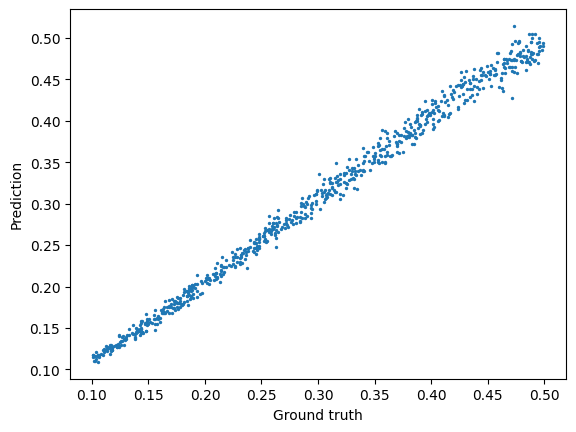

In [26]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()